In [1]:
%matplotlib widget

import gc 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata
import xgcm
from scipy.interpolate import interp1d

#from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

def flat2d(x):
    if type(x) is np.ndarray:
        x0 = np.concatenate( [np.concatenate([x[:,0,:,:],x[:,1,:,:],x[:,2,:,:]], axis=-2),
                              np.concatenate([x[:,3,:,:],x[:,4,:,:],x[:,5,:,:]], axis=-2)], axis=-1 )
        y0 = np.concatenate( [np.concatenate([x[:,7,:,:],x[:,8,:,:],x[:,9,:,:]], axis=-1),
                              np.concatenate([x[:,10,:,:],x[:,11,:,:],x[:,12,:,:]], axis=-1)], axis=-2 )
    else:
        x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                         xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
        y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                         xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

def calc_drake_passage_transport(ds):
    vtrans = (ds.VVEL*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6
    return (vtrans.sel(face=11,i=range(87,90),j_g=62).sum('i') + vtrans.sel(face=12,i=range(20),j_g=62).sum('i'))

def make_masks(coords):
    global_mask = coords.hFacC.isel(k=0)
    global_mask[6,:,:]=0. # delete Arctic face
    global_mask[2,80:,60:]=0.
    global_mask[7,:,:13]=0.
    global_mask[10,:43,:11]=0.
    # remove Hudson
    global_mask[10,30:54,5:39] = 0.
    global_mask[10,30:62,10:39] = 0.
    #
    atlantic_mask = global_mask.where(coords.YC>-35).where( # Southern Ocean
        np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
        np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
        np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
        np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific
        np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
        np.logical_or(coords.XC>-90,coords.YC>18)).where(
        np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
    indopacific_mask = (global_mask-atlantic_mask).where(
        np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
    # remove Hudson
    indopacific_mask[10,10:,:39] = 0.
    # remove Med and parts of Arctic
    indopacific_mask[ 2,20:,29:84] = 0.
    # remove Bering strait and Chukchy Sea
    indopacific_mask[ 7,:,:14] = 0.
    return global_mask, atlantic_mask, indopacific_mask

def zonal_mean(ds,fld,msk):
    # mask the Med
    dvol = flat2d(ds.hFacC*ds.rA*ds.drF*msk)
    # mask the Med
    dvol[:,200:217,33:80]=0
    dvol[:,217:222,40:60]=0
    ra = dvol.sum(axis=-1)
    ra[ra==0]=np.Inf
    fldz = (flat2d(fld)*dvol).sum(axis=-1)/ra
    return np.ma.masked_array(fldz,fldz==0)

def compute_moc(wflux):
    u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
                     xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
                     xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # order of integration: from north to south because of Atlantic MOC, requires sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

def compute_moc_layers(dl,msk):

    locmsk = msk.values
    ufx = dl.LaUH1RHO*dl.dyG*locmsk
    vfx = dl.LaVH1RHO*dl.dxG*locmsk
    # integration over longitude
    vf =  xr.concat([vfx.isel(face= 0),vfx.isel(face= 1),vfx.isel(face= 2)],dim='j_g').sum(dim='i') \
        + xr.concat([vfx.isel(face= 3),vfx.isel(face= 4),vfx.isel(face= 5)],dim='j_g').sum(dim='i')
    uf =  xr.concat([ufx.isel(face= 7),ufx.isel(face= 8),ufx.isel(face= 9)],dim='i_g').sum(dim='j') \
        + xr.concat([ufx.isel(face=10),ufx.isel(face=11),ufx.isel(face=12)],dim='i_g').sum(dim='j')
    uvf = vf.data[:,1:]-uf.data[:,:0:-1]
    # add a column of zeros at the southern end
    uvf = np.hstack((np.zeros((uvf.shape[0],1)),uvf))
    # integration over depth
    return np.cumsum(uvf,axis=0)

def calc_flux_divergence(dl):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    # layer flux in two directions
    flxx = dl.LaUH1RHO*dl.dyG
    flxy = dl.LaVH1RHO*dl.dxG
    # difference in the x and y directions
    diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
    # divergence
    return diff_flx['X'] + diff_flx['Y']

def calc_wflux_dia(dl):
    flx_div = calc_flux_divergence(dl)
    return -flx_div.reindex(l1_c=flx_div.l1_c[::-1]).cumsum(dim='l1_c')

def compute_moc_layers_div(dl,msk):

    # grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    # # compute divergence of layer flux
    # flxx = dl.LaUH1RHO*dl.dyG
    # flxy = dl.LaVH1RHO*dl.dxG
    # # difference in the x and y directions
    # diff_flx = grd.diff_2d_vector({'X': flxx, 'Y': flxy}, boundary='fill')
    # # convergence
    # divergence = diff_flx['X'] + diff_flx['Y']
    divergence = calc_flux_divergence(dl)
    # vertical integral (from bottom to top)
    wflux = -divergence.reindex(l1_c=divergence.l1_c[::-1]).cumsum(dim='l1_c')
    # add the masking here after re-reindexing
    return compute_moc(wflux.reindex(l1_c=wflux.l1_c[::-1])*msk)

def compute_layers(dl,msk):
    grd = xgcm.Grid(dl, periodic=False, face_connections=face_connections)
    lahc = grd.interp_2d_vector({'X': dl.LaHw1RHO,
                                 'Y': dl.LaHs1RHO},
                                 to = 'center', boundary='fill')
    lath = 0.5*(lahc['X']+lahc['Y'])*msk
#    lath = lath.where(msk>0.)
    u0 = xr.concat([xr.concat([lath.isel(face=0),
                               lath.isel(face=1),
                               lath.isel(face=2)], dim='j' ),
                    xr.concat([lath.isel(face=3),
                               lath.isel(face=4),
                               lath.isel(face=5)], dim='j' )], dim='i')
    v0 = xr.concat([xr.concat([lath.isel(face=7),
                               lath.isel(face=8),
                               lath.isel(face=9)], dim='i' ),
                    xr.concat([lath.isel(face=10),
                               lath.isel(face=11),
                               lath.isel(face=12)],dim='i')],dim='j')
    zz = np.concatenate((u0,np.rot90(v0,k=1,
                                     axes=(-2,-1))), axis=-1).cumsum(axis=0)
    return zz.mean(axis=-1,where=zz!=0)

def plot2dmap(ax,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "horizontal"}
            if levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()

In [2]:
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, lon_0=-60, tstr=None, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        x,y = self.new_grid_lon, self.new_grid_lat

        p = ax.pcolormesh(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)


        # ax.coastlines()
        # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
        ax.add_feature(cart.feature.LAND, facecolor='0.7', zorder=3)
        ax.gridlines()

        if tstr is not None:
            ax.set_title('%s'%(tstr))
            
        label = None
        # if da.name is not None:
        #     label = da.name
        # if 'units' in da.attrs:
        #     label += ' (%s)' % da.attrs['units']
        cbarextend='both'
        try:
            mynorm = plt_kwargs.pop('norm')
            if mynorm.vmin == 0.: cbarextend='max'
        except:
            cbarextend='both'

        shrinkfac=1.
        cb = plt.colorbar(p, ax=ax, shrink=shrinkfac, label=label, extend=cbarextend, orientation='horizontal')

        return ax

In [3]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/albedo/home/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [4]:
deltat=1800.
ny, nx = 1170, 90
# prefix=['diagsKrN2']

prefixmonthly = ['diags2DMonthly']

bdir='/albedo/work/projects/p_sochic_ws/MITgcm/llc90'
gdir='/albedo/work/projects/p_idemix_tr181/llc90/grid'
fdir='/albedo/work/projects/p_sochic_ws/MITgcm/llc90/figs'

rname0='run00'; deltat0 = 3600.
rname1='run13'; deltat1 = 3600.
rname2='run14'; deltat2 = 3600.

rnames= [rname0,rname1,rname2]
deltats= [deltat0,deltat1,deltat2]

rdirs = []
for rname in rnames:
    rdirs.append(os.path.join(bdir,rname))

rdirs=[rdirs[0]]
print(rdirs)

['/albedo/work/projects/p_sochic_ws/MITgcm/llc90/run00']


In [5]:
# find out the file numbers to read
cycle = 1
startyear = 1981
refdate = "%i-1-1 0:0:0"%(startyear-(cycle-1)*40)
rdirs[0]

'/albedo/work/projects/p_sochic_ws/MITgcm/llc90/run00'

In [6]:
d00=open_mdsdataset(rdirs[0],prefix=['diags2D'],delta_t=deltats[0],ref_date=refdate,geometry='llc')
coords = d00.coords.to_dataset().reset_coords()
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)
#
coords['XC'] = grid.XC
coords['YC'] = grid.YC
coords['XG'] = grid.XG
coords['YG'] = grid.YG
myiters=list(d00.iter.values)
print("available output slices %i, years %s to %s"%(len(myiters),
    d00.time[0].data.astype('datetime64[Y]'),d00.time[-1].data.astype('datetime64[Y]')))
# print(coords['XG'])

available output slices 40, years 1982 to 2021


In [7]:
dss = [open_mdsdataset(rdir,prefix=['diags2D','diags3D'], iters=myiters,
                       delta_t=deltats[k],ref_date=refdate,geometry='llc') #,extra_metadata=llc90_extra_metadata)
       for k,rdir in enumerate(rdirs)]
coords = dss[0].coords.to_dataset().reset_coords()
grd = xgcm.Grid(coords, periodic=False, face_connections=face_connections)

# # fix coordinates
# for ds in dss:
#     ds.coords['XC'] = grid.XC
#     ds.coords['YC'] = grid.YC
#     ds.coords['XG'] = grid.XG
#     ds.coords['YG'] = grid.YG

In [8]:
# fix coordinates
for ds in dss:
    ds.coords['XC'] = grid.XC
    ds.coords['YC'] = grid.YC
    ds.coords['XG'] = grid.XG
    ds.coords['YG'] = grid.YG
    
coords = dss[0].coords.to_dataset().reset_coords()

In [9]:
dss[0]

<xarray.Dataset>
Dimensions:   (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
               k_p1: 51, face: 13, time: 40)
Coordinates: (12/45)
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...        ...
    rhoRef    (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    dyF       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyU       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxF       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2021-01-01
Data variables: (12/14)
    ETAN      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    MXLDEPTH  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIarea    (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIheff    (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIhsnow   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIuice    (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    ...        ...
    SALT      (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL      (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL      (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    WVEL      (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    RHOAnoma  (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/albedo/work/...

# 2D surface plots

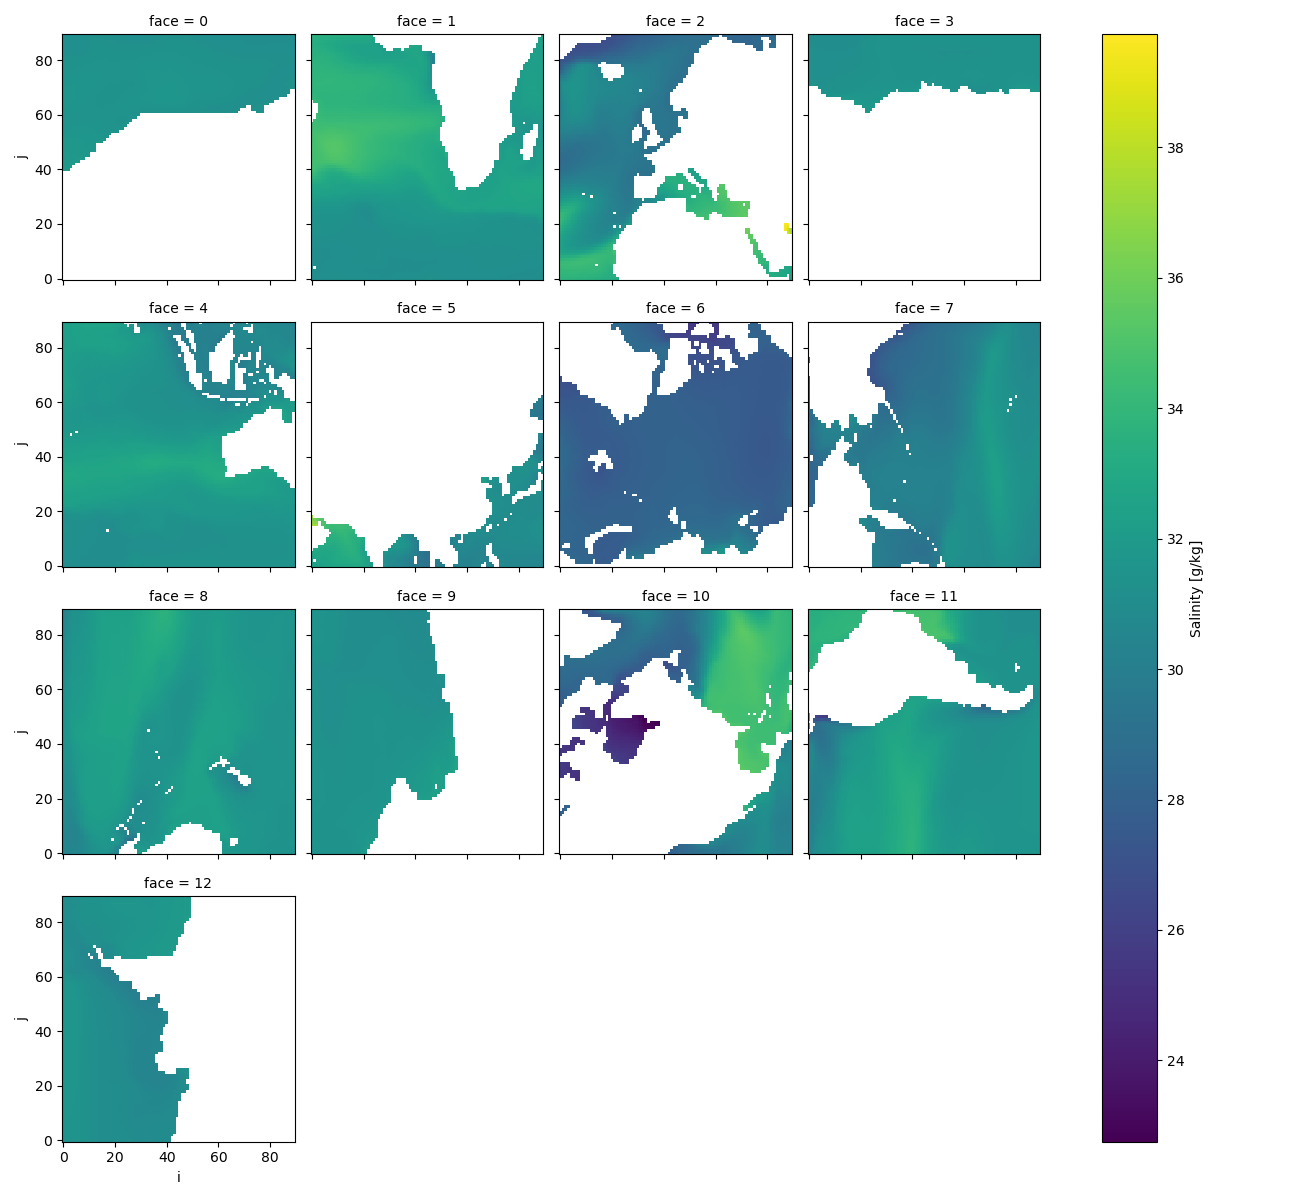

In [10]:
mask2d=(dss[0].hFacC.isel(k=0)!=0.).compute()
dss[0]
plt.close('all')
#plt.figure();
#print(dss[0].SALT.where(ds.SALT!=0.).isel(time=-1,k=0).shape)
dss[0].SALT.where(ds.SALT!=0.).isel(time=-1,k=0).plot(col='face', col_wrap=4)

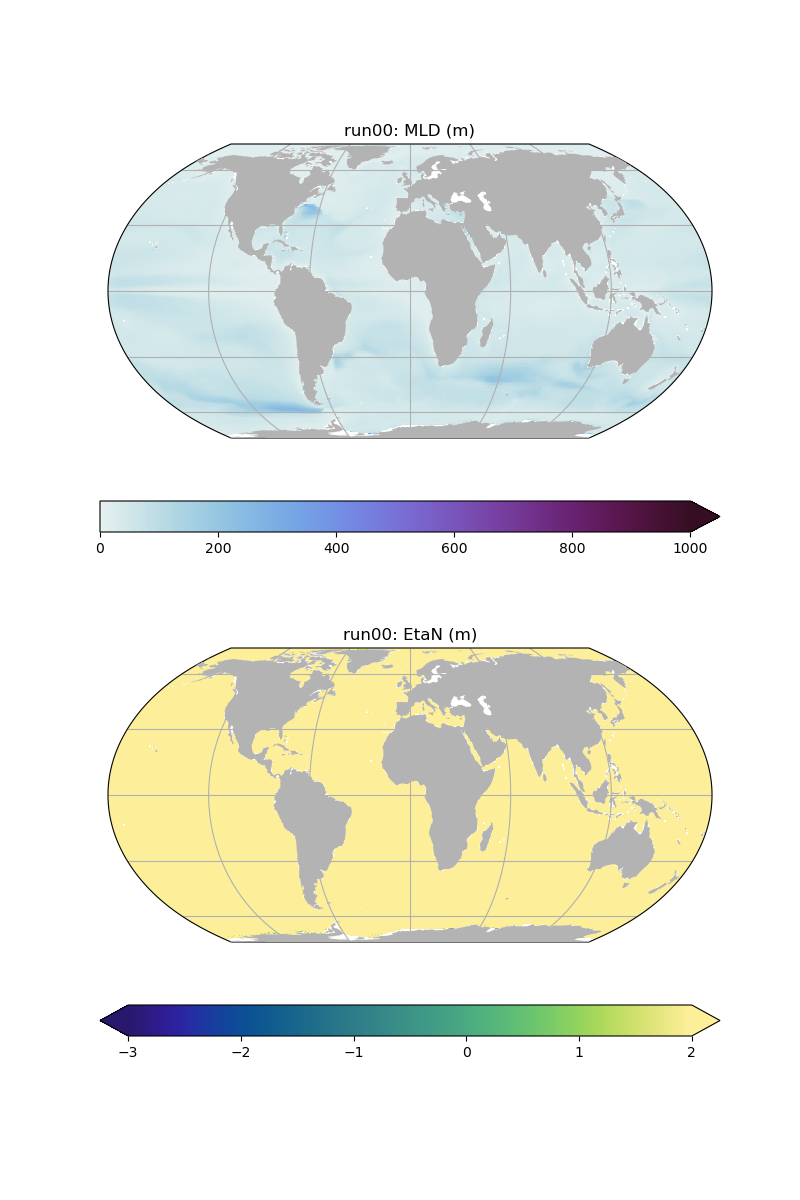

In [12]:
from matplotlib import cm

plt.close('all')
#proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
proj=cart.crs.EqualEarth()#central_longitude=180.0-19) #central_longitude=7.0)

mapper = LLCMapper(coords) #, dx=1., dy=1.)
mask2d=(dss[0].hFacC.isel(k=0)!=0.).compute()

fig, ax = plt.subplots(nrows=2,ncols=len(rdirs),sharex=True,sharey=True,figsize=(8*len(rdirs),12),subplot_kw={'projection': proj})

ax = ax.flatten()

mytime=-1
mlnorm = colors.Normalize(vmin=0,vmax=1000)
enorm = colors.Normalize(vmin=-3,vmax=2)


for k in range(len(rdirs)):
    mapper(dss[k].isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[k],norm=mlnorm,cmap=cmo.dense,tstr=rnames[k]+': MLD (m)')
    # mapper(dss[k].isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[k],norm=mlnorm,cmap=cmo.dense,tstr=rnames[k]+': MLD (m)')
    # mapper(dss[k].isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[k],norm=mlnorm,cmap=cmo.dense,tstr=rnames[k]+': MLD (m)')

for k in range(len(rdirs)):
    mapper(dss[k].isel(time=mytime).ETAN.where(mask2d),ax=ax[k+len(rdirs)],norm=enorm,cmap=cmo.haline,tstr=rnames[k]+': EtaN (m)')

#dmlnorm = colors.Normalize(vmin=-100,vmax=100)
#mapper((dss[0]-dss[1]).isel(time=mytime).MXLDEPTH.where(mask2d),ax=ax[4],norm=dmlnorm,cmap=cmo.delta,tstr='%s - %s: MLD(md)'%(rnames[0],rnames[1]))

# sections etc.

## global mean

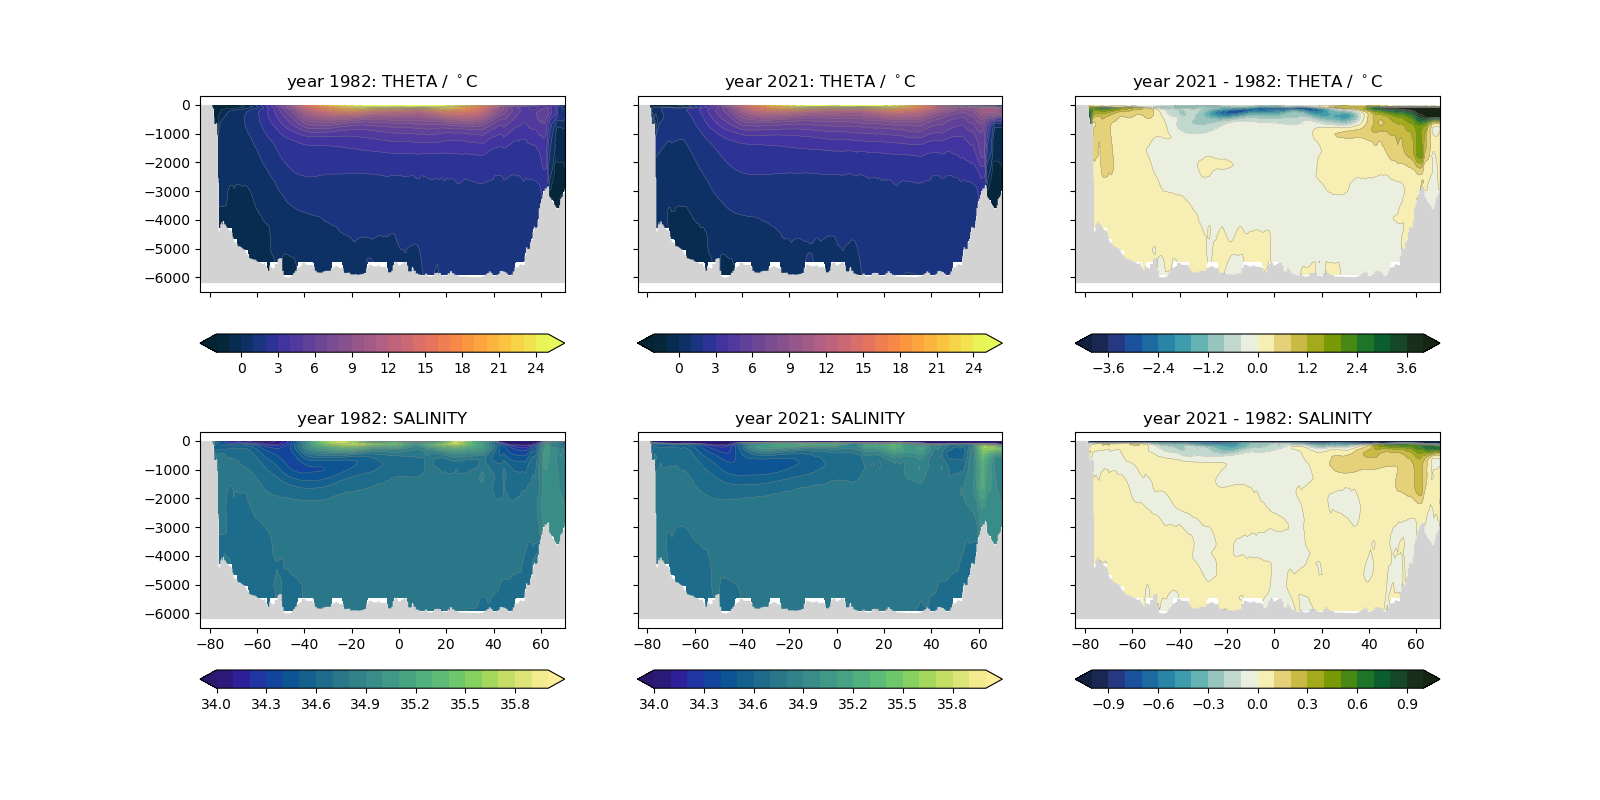

In [13]:
#plt.close('all')
import matplotlib.ticker as mtick
#mytindex = ds1.time.shape[0]-1

def format_func(x,pos):
    mystr = "%1.0e"%x
    return mystr

def plotzonalmean(ax,ds,fld,levs,msk=1.,tstr='dummy',cmap=None):
    # compute zonal mean along grid lines for now:
    y = flat2d(grid.YC).mean(axis=-1)
    fld0 = zonal_mean(ds,fld,msk)
    d = flat2d(ds.Depth*msk).max(axis=-1)
    if 'k_l' in fld.dims:
        # in this case we assume that we want to plot logarithmic color scales
        z = ds.Zl
        tickformat=mtick.LogFormatter()
        useLog=True
        if levs[0]>0:
            cnorm = colors.LogNorm(levs[0],levs[-1])
        else:
            # special trick, when logarithmic levels are negative use symmetric log scale
            cnorm = colors.SymLogNorm(linthresh=np.abs(levs[0]), linscale=2,
                                      vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            levs = np.hstack((np.flip(levs),-levs))
            # cnorm = colors.Normalize(vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            tickformat=mtick.FuncFormatter(format_func)
    else:
        z = ds.Z
        useLog=False
        cnorm = None
    csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
    ax.contour(y,z,fld0,levels=levs,colors='gray',linewidths=0.25)
    ax.fill_between(y,-d,-ds.Depth.max()-200.,step='mid',facecolor='lightgrey')
    if useLog:
        plt.colorbar(csf,ax=ax,orientation='horizontal',format=tickformat)
    else:
        plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s'%(tstr))

    
gr = 9.81/1035

global_mask, atlantic_mask, indopacific_mask = make_masks(coords)

plt.close()
fig,ax=plt.subplots(2,3,figsize=(16,8),sharex=True,sharey=True);
ax=ax.flatten()
#
dm0 = dss[0].isel(time=0)
dm1 = dss[0].isel(time=-1)
msk = global_mask
plotzonalmean(ax[0],dm0,dm0.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA / $^\circ$C'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[1],dm1,dm1.THETA,np.linspace(-2,25,28),msk,  'year %s: THETA / $^\circ$C'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.thermal)
plotzonalmean(ax[2],dm0,(dm1-dm0).THETA,np.linspace(-4,4,21),msk,'year %s - %s: THETA / $^\circ$C'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)
#msk = atlantic_mask
plotzonalmean(ax[3],dm0,dm0.SALT,np.linspace(34,36,21),msk,  'year %s: SALINITY'%np.datetime_as_string(dm0.time, unit='Y'),cmap=cmo.haline)
plotzonalmean(ax[4],dm1,dm1.SALT,np.linspace(34,36,21),msk,  'year %s: SALINITY'%np.datetime_as_string(dm1.time, unit='Y'),cmap=cmo.haline)
plotzonalmean(ax[5],dm0,(dm1-dm0).SALT,np.linspace(-1,1,21),msk,'year %s - %s: SALINITY'%(np.datetime_as_string(dm1.time, unit='Y'),np.datetime_as_string(dm0.time, unit='Y')),cmap=cmo.delta)


## sections along 30 and 170 degW

In [14]:
def plotsec30(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    ii=7
    iface=3
    fld0=np.concatenate((fld[:,0,:,ii],fld[:,1,:,ii],fld[:,2,:,ii]),axis=1)
    y = np.concatenate((ds.YC[0,:,ii],ds.YC[1,:,ii],ds.YC[2,:,ii]),axis=0)
    d = np.concatenate(ds.Depth[:iface,:,ii],axis=0)
    csf=ax.pcolormesh(y,ds.Z,fld0,norm=cnorm,cmap=cmap)
#    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='vertical')
    ax.set_title('%s, section along %i E'%(tstr,ds.XC.sel(face=1,i=ii).mean()))

def plotsec170(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    jj=47
    fld0=np.concatenate((fld[:,7,jj,:],fld[:,8,jj,:],fld[:,9,jj,:]),axis=1)
    y = np.concatenate((ds.YC[7,jj,:],ds.YC[8,jj,:],ds.YC[9,jj,:]),axis=0)
    d = np.concatenate(ds.Depth[7:10,jj,:],axis=0)
    csf=ax.pcolormesh(y,ds.Z,fld0,norm=cnorm,cmap=cmap)
#    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='vertical')
    ax.set_title('%s, section along %i E'%(tstr,ds.XC.sel(face=8,j=jj).mean()))

Text(0.5, 0.98, 'difference between 2021 and 1982')

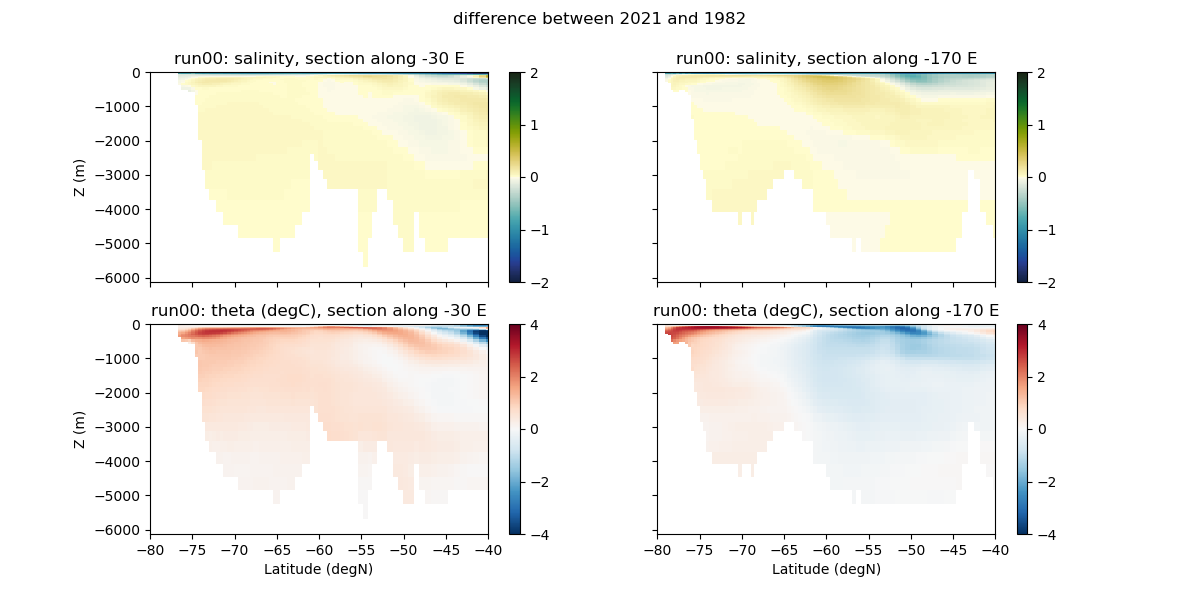

In [15]:
plt.close()
mytime=-1
k = 0
#fig,ax=plt.subplots(2,2,figsize=(18,9),sharex=True,sharey=True);
fig,ax=plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True);
ds = dss[0].isel(time=mytime) - dss[0].isel(time=0)
msk = dss[0].hFacC.where(ds.hFacC>0).values
msk[msk>0]=1

myfld = ds.SALT*msk
salt = myfld.where(myfld!=0).values
cnorm = colors.Normalize(34,36); cmap=cmo.haline
cnorm = colors.Normalize(-2,2); cmap=cmo.delta
plotsec30( ax[0,0],ds,salt,cnorm,'%s: salinity'%(rnames[k]),cmap=cmap)
plotsec170(ax[0,1],ds,salt,cnorm,'%s: salinity'%(rnames[k]),cmap=cmap)

myfld = ds.THETA*msk
theta = myfld.where(myfld!=0).values
cnorm = colors.Normalize(-1,3); cmap = cmo.thermal
cnorm = colors.Normalize(-4,4); cmap = cm.RdBu_r
plotsec30( ax[1,0],ds,theta,cnorm,'%s: theta (degC)'%(rnames[k]),cmap=cmap)
plotsec170(ax[1,1],ds,theta,cnorm,'%s: theta (degC)'%(rnames[k]),cmap=cmap)


for b in ax[1,:]: b.set_xlabel('Latitude (degN)')
for b in ax[:,0]: b.set_ylabel('Z (m)')
for b in ax.ravel():
    b.set_xlim([-80,-40])

thisyear=np.datetime_as_string(dss[0].time.isel(time=mytime), unit='Y')
firstyear=np.datetime_as_string(dss[0].time.isel(time=0), unit='Y')
#fig.suptitle('year %s'%(thisyear))
fig.suptitle('difference between %s and %s'%(thisyear,firstyear))
#fig.savefig(os.path.join(fdir,'prandlt_number_sections_y%s'%(thisyear)),dpi=300)

## Weddell Sea sections with density

In [16]:
import seawater as sw
ds0 = dss[0].isel(time=slice(None,None,dss[0].dims['time']-1))
#ds0 = dss[0].isel(time=slice(1,None,dss[0].dims['time']-2))
salt=flat2d(ds0.SALT)
theta=flat2d(ds0.THETA)
yg=flat2d(ds0.isel(time=0).YG)
xg=flat2d(ds0.XG)
yc=flat2d(ds0.YC)
xc=flat2d(ds0.XC)
#pres=np.tile(np.tile(np.abs(ds0.Z),(2,1)).reshape((2,50,1,1)),(1,1,270,360))

In [17]:
pdens=np.ma.masked_array(sw.dens(salt,theta,0),salt==0)
print(pdens.min(), pdens.max())

1015.8608 1029.458


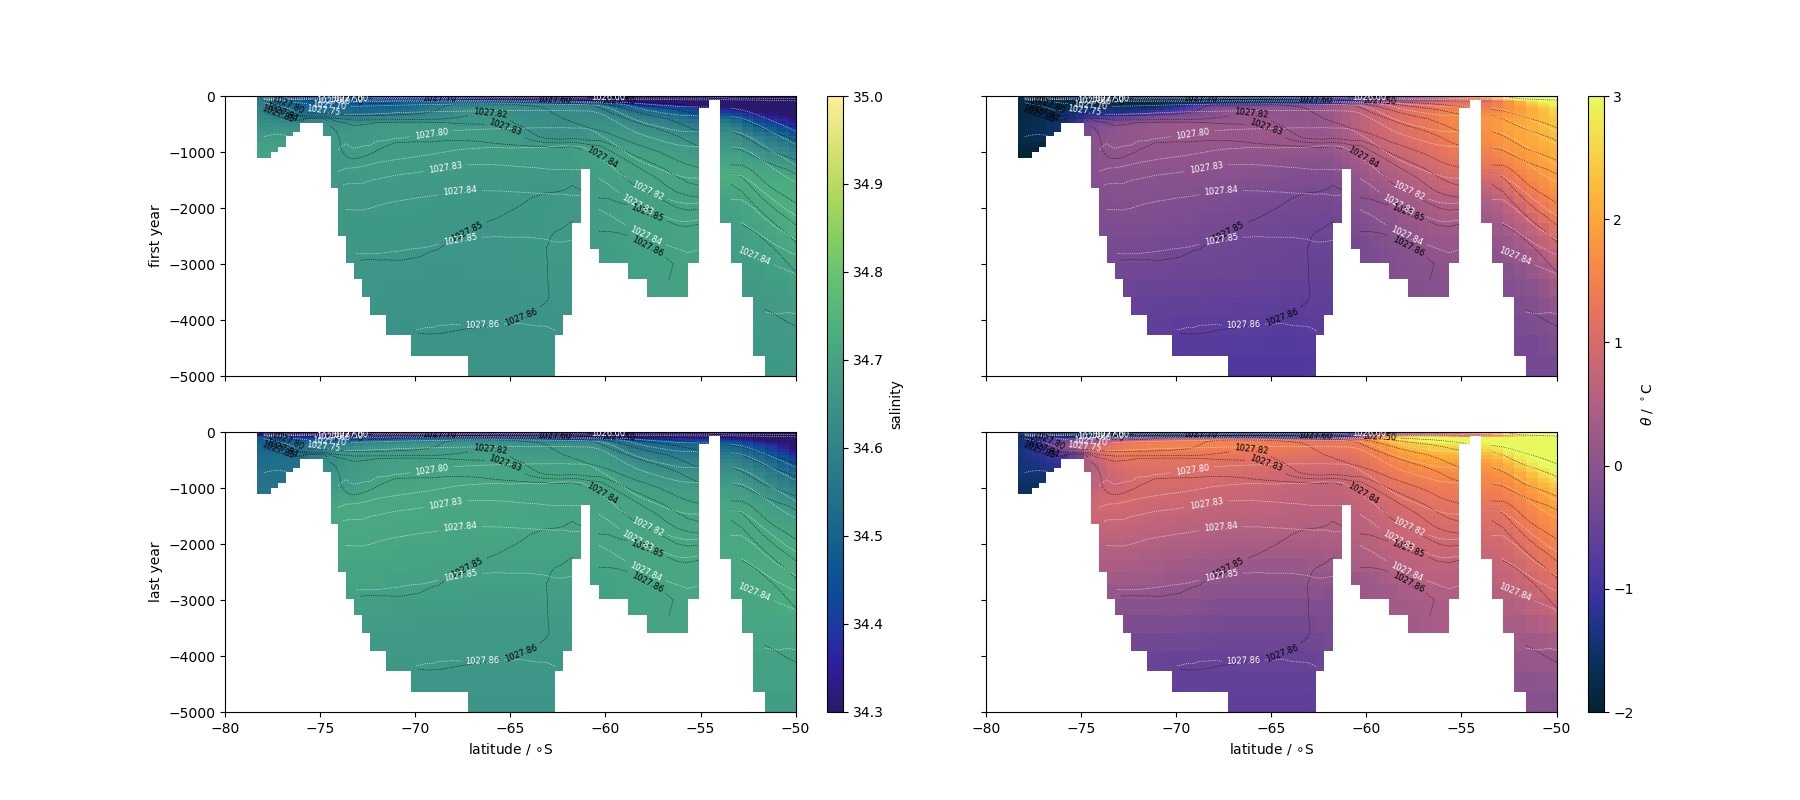

In [18]:
ii=37 #
ii=0
tt=1

plt.close('all')
fig,ax=plt.subplots(2,2,figsize=(18,8),sharex=True,sharey=True)
ax=ax.ravel()
#hm=ax.pcolormesh(yg[0,2,:,:])
yg = np.concatenate((ds.YG[0,:,ii],ds.YG[1,:,ii],ds.YG[2,:,ii]),axis=0)
yc = np.concatenate((ds.YC[0,:,ii],ds.YC[1,:,ii],ds.YC[2,:,ii]),axis=0)
hs=ax[0].pcolormesh(yg,ds.Zu,sq(salt[0,:,:,ii]),vmin=34.3,vmax=35,cmap=cmo.haline)
hs=ax[2].pcolormesh(yg,ds.Zu,sq(salt[1,:,:,ii]),vmin=34.3,vmax=35,cmap=cmo.haline)
hm=ax[1].pcolormesh(yg,ds.Zu,sq(theta[0,:,:,ii]),vmin=-2,vmax=3,cmap=cmo.thermal)
hm=ax[3].pcolormesh(yg,ds.Zu,sq(theta[1,:,:,ii]),vmin=-2,vmax=3,cmap=cmo.thermal)
plt.colorbar(hs,ax=[ax[0],ax[2]],aspect=40,fraction=0.05,label='salinity')
plt.colorbar(hm,ax=[ax[1],ax[3]],aspect=40,fraction=0.05,label=r'$\theta$ / $^\circ$C')
for b in ax.ravel():
    b.set_xlim((-80,-50))
    b.set_ylim((-5000,0))
    
ax[0].set_ylabel('first year')
ax[2].set_ylabel('last year')

ax[2].set_xlabel(r'latitude / $\circ$S')
ax[3].set_xlabel(r'latitude / $\circ$S')

dlevs=[1026,1027,1027.5,1027.6,1027.7,1027.75,1027.8,1027.82,1027.83,1027.84,1027.85,1027.86] # pref = 0
#dlevs=np.linspace(1039,1040,41) # pref=2500m
#dlevs=np.linspace(1031,1031.20,21) # pref=700m
for b in ax[:2]:
    cs=b.contour(yc,ds.Z,sq(pdens[0,:,:,ii]),levels=dlevs,colors='k',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
    cs=b.contour(yc,ds.Z,sq(pdens[1,:,:,ii]),levels=dlevs,colors='w',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
for b in ax[2:]:
    cs=b.contour(yc,ds.Z,sq(pdens[0,:,:,ii]),levels=dlevs,colors='k',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
    cs=b.contour(yc,ds.Z,sq(pdens[1,:,:,ii]),levels=dlevs,colors='w',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
    
#plt.tight_layout()


-38.0


Text(0.5, 0.98, 'Section along  61.8$^\\circ$S')

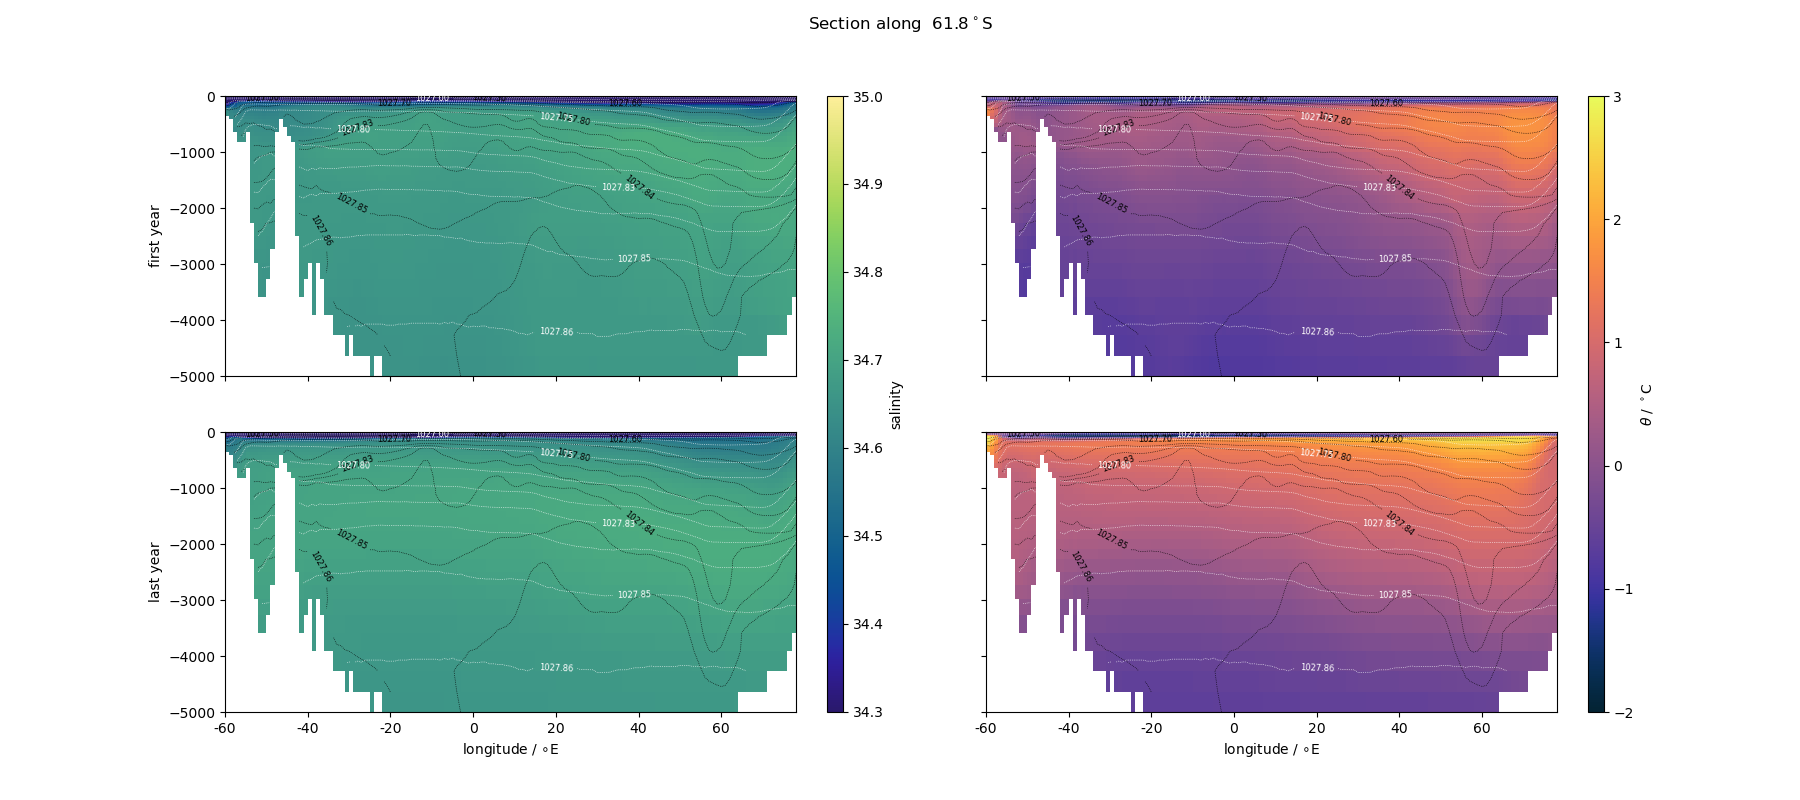

In [18]:
jj=80
tt=1

#plt.close('all')
fig,ax=plt.subplots(2,2,figsize=(18,8),sharex=True,sharey=True)
ax=ax.ravel()
#hm=ax.pcolormesh(yg[0,2,:,:])
xoff = ds.XG[0,-1,0].values
print(xoff)
xg = np.arange(360)-0.5 + xoff
xc = np.arange(360)     + xoff
ioff=22
xlabs= np.roll(xc,ioff)
xlabs[xlabs>180]=xlabs[xlabs>180]-360
hs=ax[0].pcolormesh(xg,ds.Zu,np.roll(sq(salt[0,:,jj,:]),ioff,axis=-1),vmin=34.3,vmax=35,cmap=cmo.haline)
hs=ax[2].pcolormesh(xg,ds.Zu,np.roll(sq(salt[1,:,jj,:]),ioff,axis=-1),vmin=34.3,vmax=35,cmap=cmo.haline)
hm=ax[1].pcolormesh(xg,ds.Zu,np.roll(sq(theta[0,:,jj,:]),ioff,axis=-1),vmin=-2,vmax=3,cmap=cmo.thermal)
hm=ax[3].pcolormesh(xg,ds.Zu,np.roll(sq(theta[1,:,jj,:]),ioff,axis=-1),vmin=-2,vmax=3,cmap=cmo.thermal)
plt.colorbar(hs,ax=[ax[0],ax[2]],aspect=40,fraction=0.05,label='salinity')
plt.colorbar(hm,ax=[ax[1],ax[3]],aspect=40,fraction=0.05,label=r'$\theta$ / $^\circ$C')
for b in ax.ravel():
    xticks=np.array([-60,-40,-20,0,20,40,60,80,100,120])+ioff
    b.set_xticks(xticks,xticks-ioff)
    b.set_xlim((-38,100))
    b.set_ylim((-5000,0))
    
ax[0].set_ylabel('first year')
ax[2].set_ylabel('last year')

ax[2].set_xlabel(r'longitude / $\circ$E')
ax[3].set_xlabel(r'longitude / $\circ$E')

dlevs=[1026,1027,1027.5,1027.6,1027.7,1027.75,1027.8,1027.82,1027.83,1027.84,1027.85,1027.86] # pref = 0
#dlevs=np.linspace(1039,1040,41) # pref=2500m
#dlevs=np.linspace(1031,1031.20,21) # pref=700m
pdensr=sq(np.roll(pdens[:,:,jj,:],ioff,axis=-1))
for b in ax[:2]:
    cs=b.contour(xc,ds.Z,pdensr[0,:,:],levels=dlevs,colors='k',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
    cs=b.contour(xc,ds.Z,pdensr[1,:,:],levels=dlevs,colors='w',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
for b in ax[2:]:
    cs=b.contour(xc,ds.Z,pdensr[0,:,:],levels=dlevs,colors='k',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)
    cs=b.contour(xc,ds.Z,pdensr[1,:,:],levels=dlevs,colors='w',linewidths=0.5,linestyles=':')
    b.clabel(cs, cs.levels, inline=True, fontsize=6)

fig.suptitle(r'Section along %5.1f$^\circ$S'%(np.abs(ds0.YC[0,jj,0])))
# plt.figure()
# plt.pcolormesh(np.arange(80),ds.Zu,np.hstack((theta[0,:,75,340:],theta[0,:,75,:60])))
# plt.colorbar()

(-80.0, -57.53604699005699)

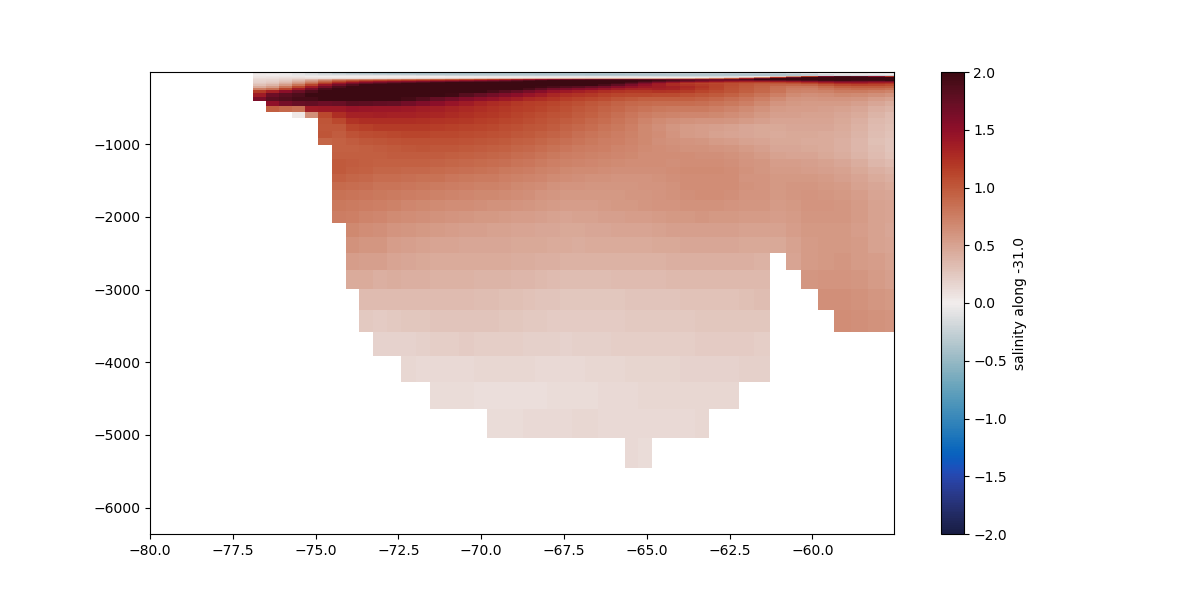

In [80]:
ii=7
iface=0
ds = dss[0].isel(time=-1)-dss[0].isel(time=0)
fig,ax=plt.subplots(1,1,figsize=(12,6))
hm=ax.pcolormesh(grid.YG[iface,:,ii],dss[0].Zu,sq(ds.THETA.isel(i=ii,face=iface)),cmap=cmo.balance,vmin=-2,vmax=2)
plt.colorbar(hm,ax=ax,label='theta along %5.1f'%(grid.XG[iface,-1,ii]))
ax.set_xlim([-80,grid.YG[iface,-1,ii]])

# trends

In [42]:
dm=dss[0]
ar = dm.hFacC[0,...]*dm.rA
vol0 = dm.hFacC*dm.rA*dm.drF
dm0 = dm
dsalt = dm0.SALT-dm0.SALT[0,...]

In [43]:
#sm = ( (dm.SALT[:,0,...]*ar).sum(axis=(-3,-2,-1))/ar.sum() )#.values
smeanlayer = ((dsalt*vol0).sum(axis=(-3,-2,-1))/vol0.sum(axis=(-3,-2,-1))).values

print('processing 50S')
msk50S = dm0.hFacC[0,...].where(dm0.YC<-50)
vol = vol0*msk50S
smeanlayer50S = ((dsalt*vol).sum(axis=(-3,-2,-1))/vol.sum(axis=(-3,-2,-1))).values
print('processing 50N')
msk50N = dm0.hFacC[0,...].where(dm0.YC>50)
vol = vol0*msk50N
smeanlayer50N = ((dsalt*vol).sum(axis=(-3,-2,-1))/vol.sum(axis=(-3,-2,-1))).values
print('processing 50')
msk50 = dm0.hFacC[0,...].where(np.logical_and(dm0.YC<50,dm0.YC>-50))
vol = vol0*msk50
smeanlayer50 = ((dsalt*vol).sum(axis=(-3,-2,-1))/vol.sum(axis=(-3,-2,-1))).values

processing 50S
processing 50N


/albedo/home/mlosch/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


processing 50


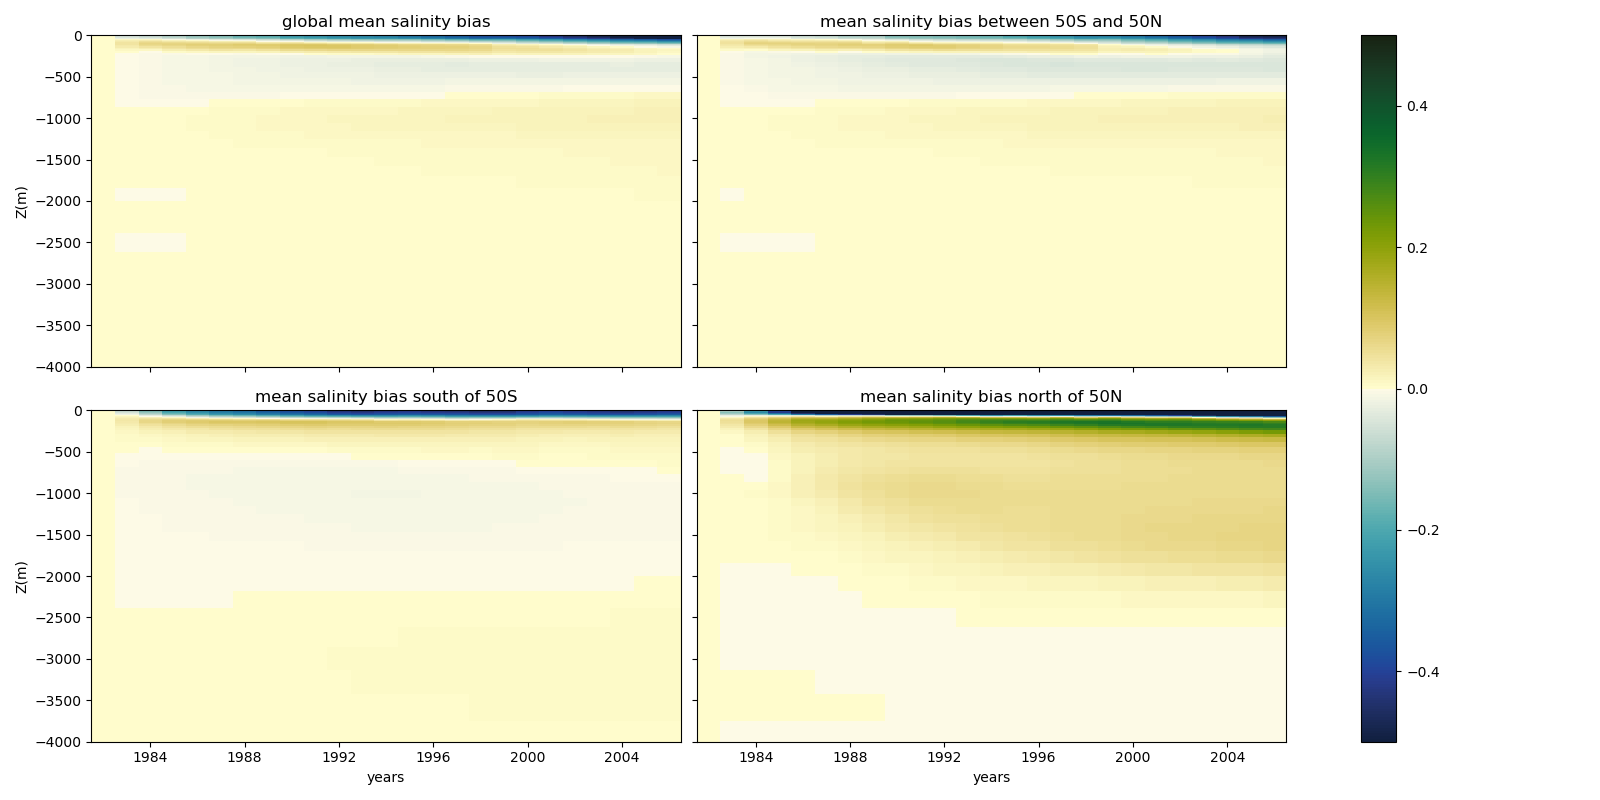

In [44]:
plt.close()
def plot_tz(ax,ds,fld,tstr):
    im=ax.pcolormesh(ds.time.values,ds.Z.values,fld,vmin=-.5,vmax=.5,cmap=cmo.delta)
    ax.set_title(tstr)

    return im

fig,ax=plt.subplots(2,2,figsize=(16,8),sharex=True,sharey=True)
ax=ax.flatten()
im=plot_tz(ax[0],dm0,smeanlayer.transpose(),'global mean salinity bias')
im=plot_tz(ax[2],dm0,smeanlayer50S.transpose(),'mean salinity bias south of 50S')
im=plot_tz(ax[3],dm0,smeanlayer50N.transpose(),'mean salinity bias north of 50N')
im=plot_tz(ax[1],dm0,smeanlayer50.transpose(),'mean salinity bias between 50S and 50N')

for b in ax: b.set_ylim([-4000,0])

for b in ax[0::2]: b.set_ylabel('Z(m)')
    
for b in ax[-2:]: b.set_xlabel('years')
plt.tight_layout()
fig.colorbar(im, ax=ax.ravel().tolist())

# overturning

In [30]:
mocstrf=[]
dp=[]

if True:
    global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
    for k,ds in enumerate(dss):
        rname=rnames[k]
        print("stream functions: processing %s"%rname)
        mocstrf.append(compute_moc(ds.WVEL*(ds.rA*atlantic_mask)*1e-6))
#        mocstrf[k].tofile(os.path.join(postprocdir,"amocstrf_%s.bin"%(rname)))
        print("drake passage transports: processing %s"%rname)
        dp.append(calc_drake_passage_transport(ds).values)
#        dp[k].tofile(os.path.join(postprocdir,"drake_passage_transp_%s.bin"%(rname)))



stream functions: processing run00
drake passage transports: processing run00


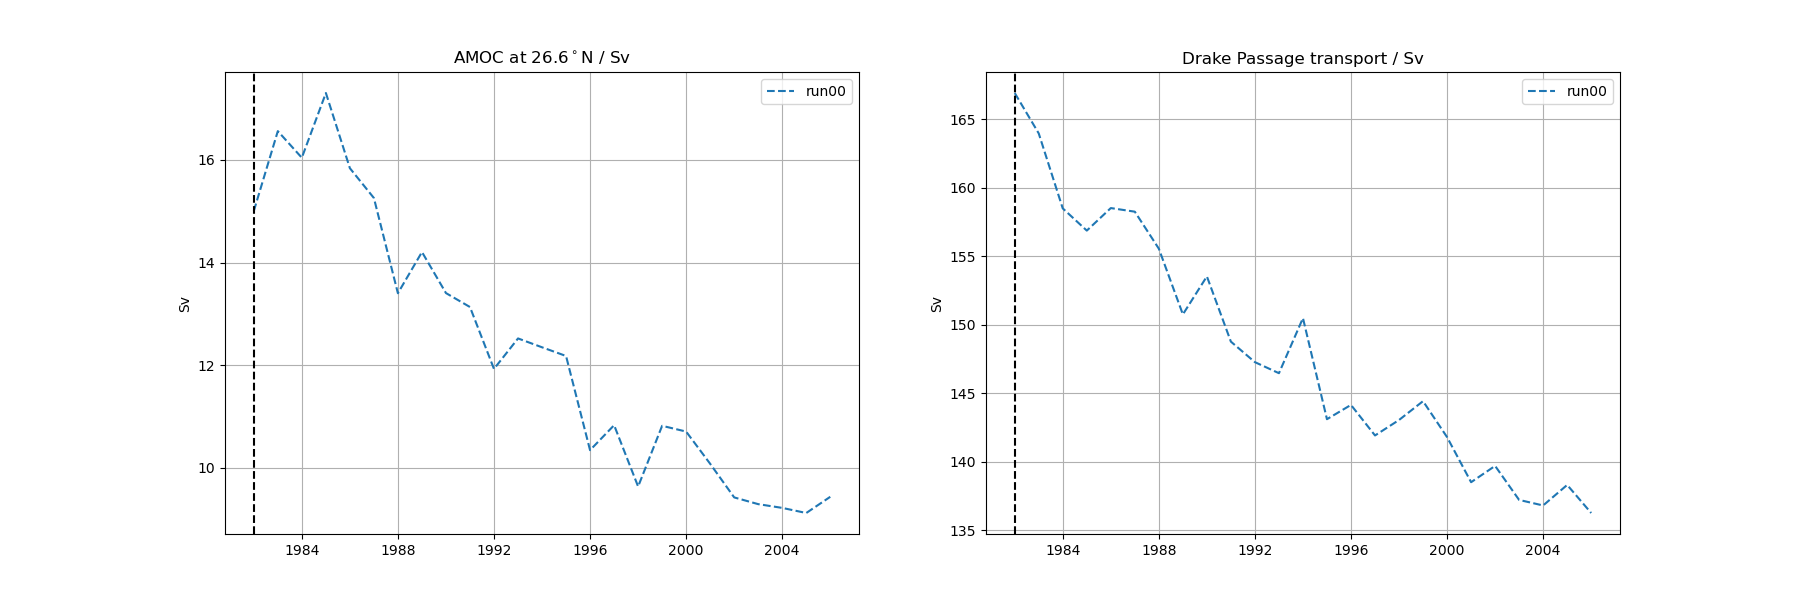

In [31]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(18,6))
#plt.clf()
y = flat2d(grid.YC).mean(axis=-1)
iz = 22 # blow 500m
iy = 165 # northern hemisphere
labs=['--','-','-.',':']
for k, ds in enumerate(dss):
    #ax[0].plot(ds.time,mocstrf[k][:,iz:,iy:].max(axis=1).max(axis=-1),labs[k],label="%s max"%(rnames[k]))
    # for iy in [195]:
    iy=197
    ax[0].plot(ds.time,mocstrf[k][:,iz:,iy].max(axis=1),labs[k],label=rnames[k])
    # ax[0].plot(ds.time,mocstrf[k][:,iz:,iy].max(axis=1),labs[k],label="%s at %4.1f$^\circ$N"%(rnames[k],y[iy]))
    
    ax[1].plot(ds.time,dp[k],labs[k],label="%s"%(rnames[k]))

ax[0].set_title('AMOC at %4.1f$^\circ$N / Sv'%y[iy])
ax[1].set_title('Drake Passage transport / Sv')

for a in ax:
    a.set_ylabel('Sv')
    a.legend()
    a.grid()
    for x in dss[0].time[0::62]:
        a.axvline(x.data,linestyle='--',color='k')


In [32]:
def plotmoc(ax,ds,msk,tstr='dummy'):
    mocstrf = compute_moc(ds.WVEL*(ds.rA*msk)*1e-6)
    yy = flat2d(grid.YC)
    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = yy.mean(axis=-1)
    #y = np.arange(y.shape[0])
    #csf=ax.pcolormesh(y,ds.Zu,sq(mocstrf),norm=symNorm(20),cmap=cmo.curl)#,vmin=-20,vmax=20)
    csf=ax.contourf(y,ds.Zu,sq(mocstrf),levels=np.linspace(-20,20,41),cmap=cmo.curl, extend='both')
    ax.fill_between(y,-d,-ds.drF.sum()-200,step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    plt.axis('tight')
    plt.grid()

Text(0.5, 0.98, 'Overturning streamfunction $\\Psi$ (Sv), year 2006')

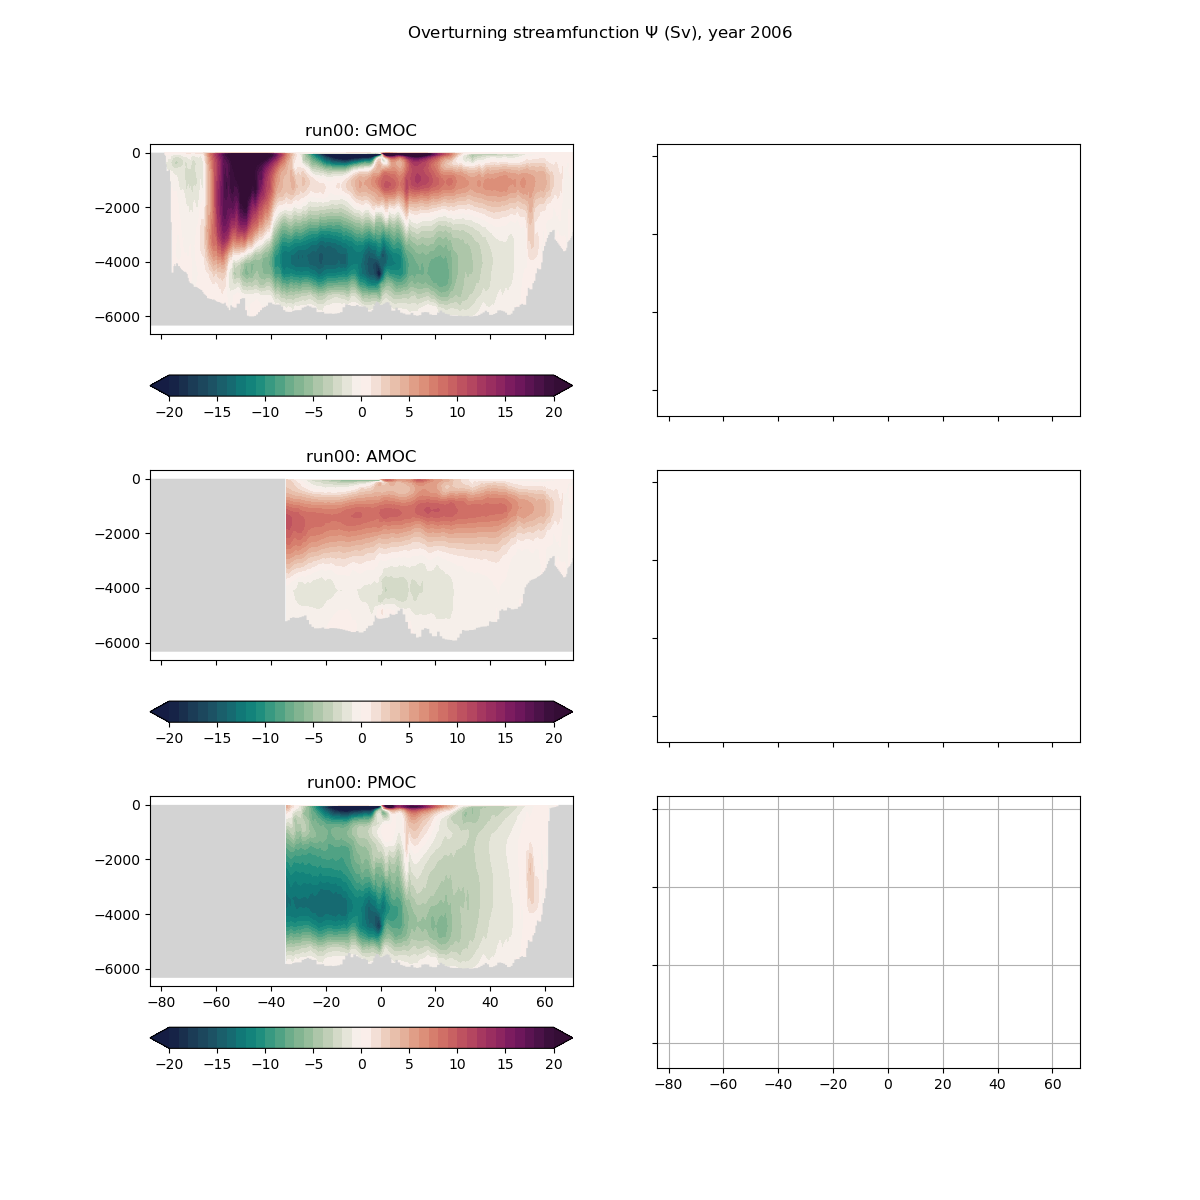

In [36]:
global_mask, atlantic_mask, indopacific_mask = make_masks(coords)
fig, ax = plt.subplots(nrows=3,ncols=max(len(rdirs),2),sharex=True,sharey=True,figsize=(6*max(2,len(rdirs)),12))#, subplot_kw={'projection': proj})
mytime = -1
#mytime = 208
for k in range(len(dss)):
    dsloc = dss[k].isel(time=mytime)
    plotmoc(ax[0,k],dsloc,     global_mask,tstr=rnames[k]+': GMOC')
    plotmoc(ax[1,k],dsloc,   atlantic_mask,tstr=rnames[k]+': AMOC')
    plotmoc(ax[2,k],dsloc,indopacific_mask,tstr=rnames[k]+': PMOC')

y0,y1 = np.datetime_as_string(dss[0].time.isel(time=0),unit='Y'), np.datetime_as_string(dss[0].time.isel(time=mytime),unit='Y')
fig.suptitle('Overturning streamfunction $\Psi$ (Sv), year %s'%(y1))
#fig.savefig(os.path.join(fdir,'moc_%s_y%s'%(rname0,yearstr)),dpi=300)

In [46]:
fid=open('/isibhv/projects/p_sochic/SOCHIC_WG6_PACKAGE/ERA5/era5_bin_1deg_6hrly/era5_rain.singleprec.bin_2020','r')
p = np.fromfile(fid,'>f4')
print(p.shape[0]/360/180)
fid.close()
p=p.reshape(int(p.shape[0]//360//180),180,360)

1464.0


1.10571555e-05


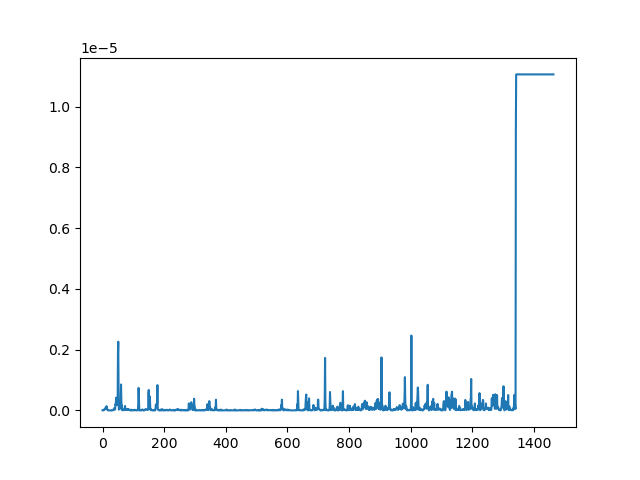

In [47]:
plt.figure();
#plt.pcolormesh(p[1342,:,:]) #,vmin=0,vmax=1e-6)
#plt.colorbar()
print(p[1342,100,200])
plt.plot(p[:,100,200])